# Tutorial: Dataset

In this tutorial we discuss how the dataset is structured, and how to load it to train a model. The dataset is hosted through xanadu.ai will be made available soon. 

## Structure

The dataset is build up of smaller subdatasets, each for a specific Hamiltonian parameter regime. Each sub folder contains four files, namely:
- config.json: contains the configuration of the dataset
- dataset.h5: contains the measurements of shape [num_samples, num_atoms]
- graph.json: contains the graph of the dataset
- properties.json: contains the observables of the dataset such as energy, magnetization, etc.

In [1]:
%load_ext autoreload
%autoreload 2

import os

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm

from rydberggpt.data.dataclasses import GridGraph
from rydberggpt.data.graph_structures import get_graph
from rydberggpt.data.rydberg_dataset import get_rydberg_dataloader
from rydberggpt.data.utils_graph import graph_to_dict
from rydberggpt.utils import shift_inputs


base_path = os.path.abspath("../")

# The system prompt

The transformer encoder takes as input a graph structure. Each graph has num_atoms nodes and each nodes has a node feature vector containing delta, omega and beta.

Lets generate an example graph and visualize it.

In [2]:
n_rows = 4
n_cols = 4
num_atoms = n_rows * n_cols

graph_config = GridGraph(
    num_atoms=num_atoms,
    graph_name="grid_graph",
    Rb=1.0,
    delta=1.0,
    omega=1.0,
    beta=1.0,
    n_rows=n_rows,
    n_cols=n_cols,
)

graph = get_graph(graph_config)
graph_dict = graph_to_dict(graph)
graph_nx = nx.node_link_graph(graph_dict)

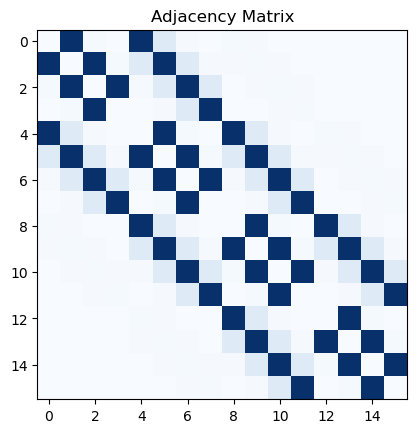

In [3]:
adj_matrix = nx.to_numpy_array(graph_nx)
plt.imshow(adj_matrix, cmap="Blues")
plt.title("Adjacency Matrix")
plt.show()

or plot the graph.

In [4]:
def plot_graph(graph):
    # Get node positions from the graph
    pos = nx.get_node_attributes(graph, "pos")

    # Extract edge weights for edge coloring
    edges, weights = zip(*nx.get_edge_attributes(graph, "weight").items())

    # Normalize edge weights for better visualization
    normalized_weights = [w / max(weights) for w in weights]

    # Calculate edge widths proportional to normalized weights
    edge_widths = [w * 2 for w in normalized_weights]

    # Create a color map for the edges
    cmap = plt.cm.Blues
    norm = mcolors.Normalize(vmin=min(normalized_weights), vmax=max(normalized_weights))

    # Plot the graph
    fig, ax = plt.subplots(figsize=(8, 8))
    nx.draw(
        graph,
        pos,
        node_color="white",
        with_labels=True,
        font_color="black",
        edge_cmap=cmap,
        node_size=400,
        width=edge_widths,
        alpha=0.5,
        edgecolors="black",
        edgelist=edges,
        edge_color=normalized_weights,
        verticalalignment="center_baseline",
        font_size=12,
    )
    plt.title("Grid Graph", fontsize=18)

    # Add a color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("1/Distance")

    plt.show()

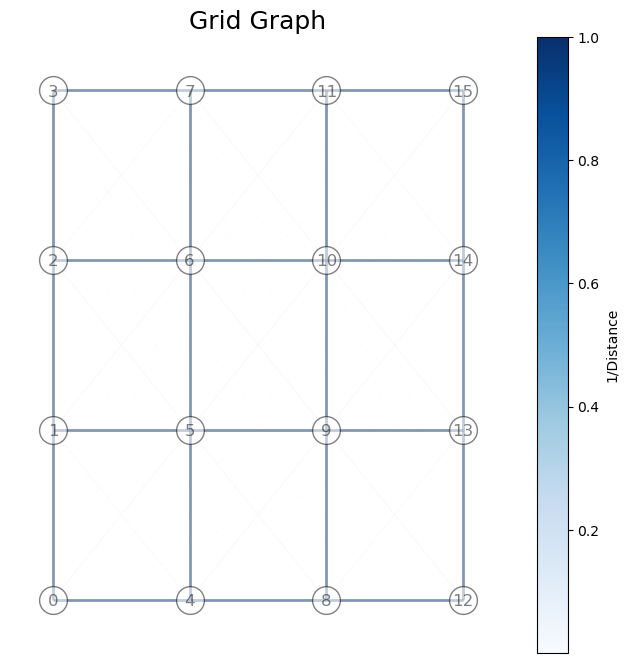

In [5]:
plot_graph(graph_nx)

Each node contains a node_feature vector encoding omega, delta and beta. 

# Loading the test dataset

We use the datapipes provided via [torchdata](https://pytorch.org/data/main/index.html) to load the dataset. During training we sample from the dataset a list of `buffer_size` subset datasets, and then sample from this new smaller dataset the training batch.

Each batch contains a datastructure with 2 elements (see rydberggpt.data.dataclasses). 
The first element is a pytorch_geometrich graph object ( `batch.graph`, based on the [batch](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Batch.html)). Each graph has num_atoms nodes and each nodes has a node feature vector containing delta, omega and beta. Finally we need the measurement data. These are one-hot encoded and stored in a tensor of shape [num_samples, num_atoms, 2]. 

```python
@dataclass
class Batch:
    graph: Data
    m_onehot: torch.Tensor
```

In [6]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    batch_size = 128
    buffer_size = 2
    num_workers = 0

    data_path = os.path.join(base_path, "src/rydberggpt/tests/dataset_test/")


    dataloader = get_rydberg_dataloader(
        batch_size=batch_size,
        data_path=data_path,
        buffer_size=buffer_size,
        num_workers=num_workers,
    )


    counter = 0
    for batch in dataloader:
        print(batch.m_onehot.shape)
        m_shifted_onehot = shift_inputs(batch.m_onehot)
        print(m_shifted_onehot.shape)


        counter += 1

        if counter > 1:
            break

torch.Size([128, 36, 2])
torch.Size([128, 36, 2])
torch.Size([128, 36, 2])
torch.Size([128, 36, 2])
